In [1]:
using Revise

In [2]:
using ModelVerification

In [3]:
using LazySets
using PyCall
using CSV
using ONNX
using Flux
using Test
using NNlib
using ONNXNaiveNASflux
using NaiveNASflux
using Zygote
# using DataFrames
# import Flux: flatten

In [4]:
# using Flux: onehotbatch, onecold, flatten
# using Flux.Losses: logitcrossentropy
# using Statistics: mean
using CUDA
using MLDatasets: CIFAR10, MNIST
using MLUtils: splitobs, DataLoader
using Accessors
using Profile
using LinearAlgebra
using Einsum

In [5]:
function test_mlp(prop_method)
    small_nnet_file = "/home/verification/ModelVerification.jl/test/networks/small_nnet.nnet"
    # small_nnet encodes the simple function 24*max(x + 1.5, 0) + 18.5
    small_nnet = read_nnet(small_nnet_file, last_layer_activation = ModelVerification.ReLU())
    flux_model = Flux.Chain(small_nnet)
    #ONNXNaiveNASflux.save("/home/verification/ModelVerification.jl/small_nnet.onnx", flux_model, (1,1))
    #println(flux_model)
    #println(flux_model.layers[1].weight, " ", flux_model.layers[1].bias) # max(x+1.5, 0) max(x+1.5, 0)              [0,4]
    #println(flux_model.layers[2].weight, " ", flux_model.layers[2].bias) # 4*max(x+1.5, 0)+2.5 4*max(x+1.5, 0)+2.5  [2.5, 18.5]
    #println(flux_model.layers[3].weight, " ", flux_model.layers[3].bias) # 24*max(x+1.5, 0)+18.5                    [18.5, 114.5]
    in_hyper  = Hyperrectangle(low = [-2.5], high = [2.5]) # expected out: [18.5, 114.5]
    out_violated    = Hyperrectangle(low = [19], high = [114]) # 20.0 ≤ y ≤ 90.0
    out_holds = Hyperrectangle(low = [18], high = [115.0]) # -1.0 ≤ y ≤ 50.0
    comp_violated    = Complement(Hyperrectangle(low = [10], high = [19])) # y ≤ 10.0 or 19 ≤ y
    comp_holds    = Complement(Hyperrectangle(low = [115], high = [118])) # y ≤ 10.0 or 18 ≤ y
    info = nothing
    search_method = BFS(max_iter=100, batch_size=1)
    split_method = Bisect(1)
    @test verify(search_method, split_method, prop_method, Problem("/home/verification/ModelVerification.jl/small_nnet.onnx", in_hyper, out_holds)).status == :holds
    @test verify(search_method, split_method, prop_method, Problem("/home/verification/ModelVerification.jl/small_nnet.onnx", in_hyper, out_violated)).status == :violated
    @test verify(search_method, split_method, prop_method, Problem("/home/verification/ModelVerification.jl/small_nnet.onnx", in_hyper, comp_holds)).status == :holds
    @test verify(search_method, split_method, prop_method, Problem("/home/verification/ModelVerification.jl/small_nnet.onnx", in_hyper, comp_violated)).status == :violated
    #= @test verify(search_method, split_method, prop_method, Problem(flux_model, in_hyper, out_holds)).status == :holds
    @test verify(search_method, split_method, prop_method, Problem(flux_model, in_hyper, out_violated)).status == :violated
    @test verify(search_method, split_method, prop_method, Problem(flux_model, in_hyper, comp_holds)).status == :holds
    @test verify(search_method, split_method, prop_method, Problem(flux_model, in_hyper, comp_violated)).status == :violated =#
end
@timed begin
    #for i in 1:1
        test_mlp(AlphaCrown(Crown(true, true), true, false, Flux.Optimiser(Flux.ADAM(0.1)), 10))
        #test_mlp(Ai2z())
        #test_mlp(Crown(true, true))
        #test_mlp(StarSet(Crown(true, true)))
    #end
end

(value = Test Passed, time = 183.240685893, bytes = 9587618567, gctime = 4.336940839, gcstats = Base.GC_Diff(9587618567, 270, 41, 171108652, 64487, 1623, 4336940839, 32, 0))

In [6]:
model = Chain([
    Conv((3, 3), 3 => 8, relu, pad=SamePad(), stride=(2, 2)), #pad=SamePad() ensures size(output,d) == size(x,d) / stride.
    BatchNorm(8),
    MeanPool((2,2)),
    SkipConnection(
        Chain([
            Conv((5, 5), 8 => 8, relu, pad=SamePad(), stride=(1, 1))
            ]),
        +
    ),
    #ConvTranspose((3, 3), 8 => 4, relu, pad=SamePad(), stride=(2, 2)),#pad=SamePad() ensures size(output,d) == size(x,d) * stride.
    Flux.flatten,
    Dense(512, 100, relu),
    Dense(100, 10)
])
testmode!(model)
# image_seeds = CIFAR10(:train)[1:5].features # 32 x 32 x 3 x 5
image_seeds = [CIFAR10(:train)[i].features for i in 1:2]
input_set = ImageConvexHull(image_seeds)
# println(typeof(image_seeds[1][1,1,1,1]))
search_method = BFS(max_iter=1, batch_size=1)
split_method = Bisect(1)
output_set = BallInf(zeros(10), 1.0)
# onnx_model_path = "/home/verification/ModelVerification.jl/mlp.onnx"
flux_model = model
image_shape = (32, 32, 3, 5)
println(image_seeds)

Array{Float32, 3}[

[0.23137255

 0.0627451 0.09803922 0.12941177 0.19607843 0.2784314 0.38039216 0.4509804 0.5372549 0.6039216 0.6039216 0.5686275 0.5568628 0.61960787 0.5686275 0.5803922 0.58431375 0.5764706 0.59607846 0.5686275 0.56078434 0.56078434 0.5529412 0.56078434 0.58431375 0.6745098 0.7921569 0.84705883 0.8627451 0.8156863 0.7058824 0.69411767; 0.16862746 0.0 0.0627451 0.14901961 0.23137255 0.32941177 0.43529412 0.46666667 0.5019608 0.6039216 0.60784316 0.57254905 0.5529412 0.6039216 0.58431375 0.57254905 0.56078434 0.5254902 0.45882353 0.49803922 0.49803922 0.49019608 0.5137255 0.54509807 0.52156866 0.5647059 0.73333335 0.75686276 0.7882353 0.7882353 0.6784314 0.65882355; 0.19607843 0.07058824 0.19215687 0.34117648 0.4 0.43137255 0.48235294 0.50980395 0.5176471 0.6117647 0.6117647 0.57254905 0.54901963 0.5568628 0.5764706 0.5686275 0.5647059 0.54901963 0.44705883 0.5019608 0.5058824 0.5137255 0.54509807 0.5411765 0.53333336 0.5294118 0.5921569 0.65882355 0.7294118 0.7764706 0.7294118 0.7019608; 0.26666668 

 0.21960784 0.21960784 0.38039216 0.5921569; 0.5803922 0.47843137 0.42745098 0.36862746 0.2627451 0.1254902 0.25882354 0.4 0.5254902 0.52156866 0.5254902 0.52156866 0.52156866 0.5411765 0.50980395 0.4862745 0.44705883 0.5019608 0.5921569 0.54901963 0.53333336 0.7019608 0.78039217 0.74509805 0.6039216 0.53333336 0.45882353 0.2784314 0.12941177 0.20784314 0.3254902 0.48235294;;; 0.24313726 0.078431375 0.09411765 0.09803922 0.1254902 0.1882353 0.27058825 0.32156864 0.39215687 0.47058824 0.47843137 0.44705883 0.4509804 0.5137255 0.4509804 0.45490196 0.4509804 0.43529412 0.44705883 0.4117647 0.40784314 0.40784314 0.4 0.40392157 0.41960785 0.5019608 0.6156863 0.68235296 0.7137255 0.6666667 0.54509807 0.5647059; 0.18039216 0.0 0.02745098 0.078431375 0.1254902 0.20784314 0.29411766 0.29803923 0.32156864 0.4392157 0.45882353 0.42745098 0.41568628 0.46666667 0.42745098 0.39215687 0.37254903 0.34509805 0.29411766 0.32156864 0.3137255 0.29803923 0.3137255 0.34117648 0.3137255 0.34509805 0.5058824 

0.37254903 0.3529412 0.35686275 0.38431373 0.38039216 0.35686275 0.45490196 0.48235294 0.3372549 0.25490198 0.36078432 0.45490196 0.47843137 0.44313726 0.4745098 0.62352943 0.7176471 0.6784314 0.5647059 0.52156866 0.5803922 0.72156864; 0.49019608 0.3254902 0.32941177 0.33333334 0.18431373 0.039215688 0.23921569 0.36078432 0.3372549 0.3372549 0.3372549 0.34117648 0.34901962 0.34901962 0.34901962 0.34509805 0.37254903 0.46666667 0.4117647 0.2901961 0.32156864 0.45490196 0.53333336 0.58431375 0.64705884 0.70980394 0.60784316 0.3647059 0.11372549 0.12156863 0.24313726 0.4627451; 0.4862745 0.34117648 0.28627452 0.24313726 0.16470589 0.050980393 0.18431373 0.2901961 0.37254903 0.36078432 0.3647059 0.36078432 0.35686275 0.38039216 0.36078432 0.34509805 0.32156864 0.4 0.5019608 0.4745098 0.46666667 0.63529414 0.72156864 0.68235296 0.5176471 0.41960785 0.3372549 0.1882353 0.07450981 0.13333334 0.20784314 0.36078432;;; 0.24705882 0.078431375 0.08235294 0.06666667 0.08235294 0.11372549 0.15686275

 0.24313726 0.22745098 0.24313726 0.13333334 0.050980393 0.0627451 0.13333334 0.12156863 0.05490196 0.078431375 0.12156863 0.15294118 0.18039216 0.22352941 0.18039216 0.043137256 0.0 0.22352941; 0.40784314 0.23529412 0.22745098 0.19607843 0.1254902 0.09411765 0.11372549 0.13333334 0.1882353 0.20392157 0.22352941 0.22352941 0.22352941 0.21960784 0.23529412 0.20392157 0.21568628 0.12941177 0.050980393 0.05490196 0.16862746 0.13725491 0.03137255 0.015686275 0.09411765 0.17254902 0.27450982 0.4 0.38431373 0.23529412 0.22352941 0.40784314; 0.42352942 0.21568628 0.19607843 0.19607843 0.105882354 0.05882353 0.14509805 0.12941177 0.16862746 0.20392157 0.21568628 0.2 0.20392157 0.23529412 0.23529412 0.19215687 0.18039216 0.14901961 0.0627451 0.05882353 0.19607843 0.15294118 0.039215688 0.03529412 0.16470589 0.34117648 0.41568628 0.4117647 0.34117648 0.27450982 0.36862746 0.54901963; 0.4 0.19607843 0.19607843 0.1882353 0.09019608 0.0 0.14901961 0.23137255 0.1764706 0.1764706 0.18039216 0.1803921

0.36862746 0.4627451 0.4 0.23137255 0.3529412; 0.21960784 0.25490198 0.25490198 0.27058825 0.3529412 0.34117648 0.3372549 0.38039216 0.32941177 0.27058825 0.3764706 0.6862745 0.72156864 0.70980394 0.78431374 0.78431374 0.7921569 0.8235294 0.8156863 0.81960785 0.8 0.80784315 0.5882353 0.1882353 0.20392157 0.2509804 0.2784314 0.28235295 0.3372549 0.21568628 0.19215687 0.45490196; 0.3019608 0.32941177 0.3254902 0.38039216 0.36862746 0.38431373 0.3372549 0.28627452 0.25490198 0.29411766 0.28235295 0.48235294 0.7254902 0.7058824 0.7372549 0.70980394 0.65882355 0.7019608 0.75686276 0.84705883 0.827451 0.8352941 0.64705884 0.20784314 0.1254902 0.19215687 0.16862746 0.16862746 0.33333334 0.1254902 0.21176471 0.5254902; 0.36862746 0.36078432 0.3529412 0.34509805 0.27058825 0.29803923 0.3529412 0.30980393 0.21960784 0.3137255 0.4 0.43529412 0.57254905 0.7607843 0.7176471 0.7254902 0.5372549 0.53333336 0.654902 0.7882353 0.8156863 0.827451 0.68235296 0.21960784 0.09411765 0.09803922 0.09803922 0.

 0.7372549 0.7294118 0.72156864 0.70980394 0.7176471 0.627451 0.30980393 0.105882354 0.34901962 0.38431373 0.33333334 0.33333334 0.32156864 0.17254902 0.050980393 0.2509804; 0.23529412 0.31764707 0.37254903 0.3137255 0.32156864 0.29803923 0.26666668 0.38039216 0.34117648 0.40784314 0.6745098 0.7176471 0.63529414 0.6901961 0.6901961 0.72156864 0.7372549 0.72156864 0.72156864 0.7254902 0.72156864 0.7529412 0.47058824 0.10980392 0.25490198 0.2 0.23529412 0.3647059 0.4745098 0.42352942 0.2509804 0.3529412; 0.22352941 0.2627451 0.2627451 0.28235295 0.3647059 0.3372549 0.33333334 0.3764706 0.32156864 0.26666668 0.37254903 0.6627451 0.6745098 0.6392157 0.7176471 0.7372549 0.7372549 0.70980394 0.69803923 0.7254902 0.72156864 0.7411765 0.5254902 0.1254902 0.14901961 0.2 0.23921569 0.2509804 0.31764707 0.21960784 0.19215687 0.44313726; 0.30588236 0.3372549 0.3372549 0.39215687 0.38039216 0.3882353 0.33333334 0.28235295 0.24705882 0.28627452 0.27450982 0.47843137 0.7019608 0.654902 0.6784314 0.65

0.34117648 0.32156864 0.36078432 0.39215687 0.4 0.37254903 0.4392157 0.61960787 0.6431373 0.59607846 0.54509807 0.5372549 0.52156866 0.52156866 0.5058824 0.47058824 0.44705883 0.4 0.4117647 0.52156866 0.26666668 0.09411765 0.09019608 0.37254903 0.5254902 0.42745098 0.38431373 0.3764706 0.18431373 0.03529412 0.16470589; 0.27058825 0.3372549 0.3882353 0.34509805 0.32941177 0.32156864 0.27058825 0.3647059 0.3764706 0.50980395 0.6392157 0.5058824 0.5137255 0.54901963 0.5568628 0.5647059 0.54901963 0.5372549 0.5137255 0.49803922 0.5254902 0.47058824 0.21568628 0.101960786 0.40784314 0.4745098 0.41568628 0.4117647 0.39607844 0.22352941 0.078431375 0.2627451; 0.23921569 0.3019608 0.3372549 0.25882354 0.25882354 0.2509804 0.21960784 0.3254902 0.27058825 0.32156864 0.57254905 0.5882353 0.49803922 0.54509807 0.5294118 0.53333336 0.5372549 0.54901963 0.5372549 0.52156866 0.52156866 0.57254905 0.36078432 0.11764706 0.28627452 0.23921569 0.28235295 0.41568628 0.5294118 0.47843137 0.3019608 0.396078

0.52156866; 0.32941177 0.3137255 0.29411766 0.27450982 0.19607843 0.21568628 0.27058825 0.23529412 0.15686275 0.25882354 0.36078432 0.42745098 0.50980395 0.6039216 0.50980395 0.5137255 0.34117648 0.30588236 0.39607844 0.52156866 0.5529412 0.57254905 0.49019608 0.13725491 0.050980393 0.08235294 0.101960786 0.14509805 0.11372549 0.05490196 0.28627452 0.53333336; 0.2784314 0.30588236 0.2509804 0.2509804 0.23529412 0.22352941 0.28235295 0.32156864 0.29803923 0.28627452 0.32941177 0.34509805 0.33333334 0.5372549 0.5921569 0.5294118 0.53333336 0.44313726 0.4 0.50980395 0.56078434 0.5568628 0.50980395 0.15686275 0.05490196 0.20784314 0.33333334 0.48235294 0.32941177 0.14117648 0.3764706 0.54509807; 0.2784314 0.24313726 0.21568628 0.20784314 0.22352941 0.2784314 0.2627451 0.2784314 0.27058825 0.20392157 0.3019608 0.29411766 0.2509804 0.2627451 0.5372549 0.5764706 0.5254902 0.5529412 0.5372549 0.5372549 0.5372549 0.5254902 0.52156866 0.28235295 0.17254902 0.2 0.30980393 0.43529412 0.28627452 0.

In [ ]:
prop_method = ImageStar()
@timed verify(search_method, split_method, prop_method, Problem(onnx_model_path, Flux_model, image_shape, image_seeds, output_set))

In [ ]:
prop_method = ImageZono()
@timed verify(search_method, split_method, prop_method, Problem(onnx_model_path, Flux_model, image_shape, image_seeds, output_set))

In [ ]:
Profile.clear()
@profile verify(search_method, split_method, prop_method, Problem(model, image_seeds, output_set))

In [ ]:
open("./prof.txt", "w") do s
    Profile.print(IOContext(s, :displaysize => (24, 500)))
end

In [7]:
using MLDatasets:MNIST
using JLD2
using Plots

In [8]:
model = Chain(
    Conv((5, 5), 1=>6, relu),
    MeanPool((2, 2)),
    Conv((5, 5), 6=>16, relu),
    MeanPool((2, 2)),
    Flux.flatten,
    Dense(256 => 120, relu),
    Dense(120 => 84, relu), 
    Dense(84 => 10),
)

loaded_state = JLD2.load("runs/lenet.jld2", "lenet_state");
Flux.loadmodel!(model, loaded_state)


Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MeanPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MeanPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

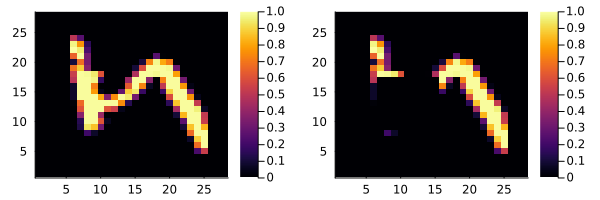

HPolyhedron{Float64, Vector{Float64}}(HalfSpace{Float64, Vector{Float64}}[HalfSpace{Float64, Vector{Float64}}([1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0, 0.0], 0.0), HalfSpace{Float64, Vector{Float64}}([0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0], 0.0)])

In [34]:
img = MNIST(:train)[1].features
label = MNIST(:train)[1].targets
img_blocked = copy(img)
# img_blocked[10,9] = 0
img_blocked[9:17,7:15] .= 0
# img_blocked[9:12,7:10] .= 0
# img_blocked[5:7,5:7] .= 1
# img_blocked[5:17,12:20] .= 1
# println(label)
p1 = heatmap(img)
p2 = heatmap(img_blocked)
display(plot(p1, p2, layout=(1,2), size=(600,200)))
img = reshape(img, (28,28,1))
img_blocked = reshape(img_blocked, (28,28,1))
input_set = ImageConvexHull([img, img_blocked])
search_method = BFS(max_iter=1, batch_size=1)
split_method = Bisect(1)
output_set = classification_spec(10, label+1) # label start from 0

In [ ]:
prop_method = ImageStar()
verify(search_method, split_method, prop_method, Problem(model, input_set, output_set))

In [43]:
prop_method = ImageStar(ImageZono())
verify(search_method, split_method, prop_method, Problem(model, input_set, output_set))

BasicResult(:holds)

In [45]:
prop_method = ImageZono()
verify(search_method, split_method, prop_method, Problem(model, input_set, output_set))

BasicResult(:unknown)

In [47]:
prop_method = ImageZono()
visualize(search_method, split_method, prop_method, Problem(model, input_set, output_set), "./mnist_vis/", true)

(Zonotope{Float32, Vector{Float32}, Matrix{Float32}}[Zonotope{Float32, Vector{Float32}, Matrix{Float32}}(Float32[-0.5277, -0.90269494, 1.1453447, 4.3595214, -6.1040974, 6.716668, -0.6144891, -1.6940199, -0.16588245, -1.799325], Float32[0.2898612 -6.845387f-6 … 2.24297f-5 0.00999979; 1.6083461 1.147392f-5 … 5.0684153f-5 0.009457583; … ; -1.2086707 -5.9636386f-6 … 1.369713f-5 0.009487128; -1.5677129 -2.3394132f-5 … 2.7157448f-5 -0.0031422544])], Dict{Any, Any}("relu_1" => Dict{Any, Any}(:out => [0.024659324 0.024659324 … 0.21665974 0.14256477; 0.024659324 0.024659324 … 0.71931297 0.4408558; … ; 0.024659324 0.2557081 … 0.024659324 0.024659324; 0.024659324 0.08443515 … 0.024659324 0.024659324;;; 0.024063924 0.024063924 … 0.1496066 0.12758215; 0.024063924 0.024063924 … 0.53835475 0.43354774; … ; 0.024063924 0.18693045 … 0.024063924 0.024063924; 0.024063924 0.07156022 … 0.024063924 0.024063924;;; 0.010716659 0.010716659 … 0.14359707 0.11574196; 0.010716659 0.010716659 … 0.53528476 0.4131547;